Using device: cpu
Epoch 1: Train Acc: 0.9082, Val Acc: 0.9577
Epoch 2: Train Acc: 0.9992, Val Acc: 0.9423
Epoch 3: Train Acc: 0.9967, Val Acc: 0.9538
Epoch 4: Train Acc: 1.0000, Val Acc: 0.9615
Epoch 5: Train Acc: 0.9992, Val Acc: 0.9538
Epoch 6: Train Acc: 1.0000, Val Acc: 0.9654
Epoch 7: Train Acc: 1.0000, Val Acc: 0.9577
Epoch 8: Train Acc: 1.0000, Val Acc: 0.9615
Epoch 9: Train Acc: 1.0000, Val Acc: 0.9615
Epoch 10: Train Acc: 1.0000, Val Acc: 0.9615


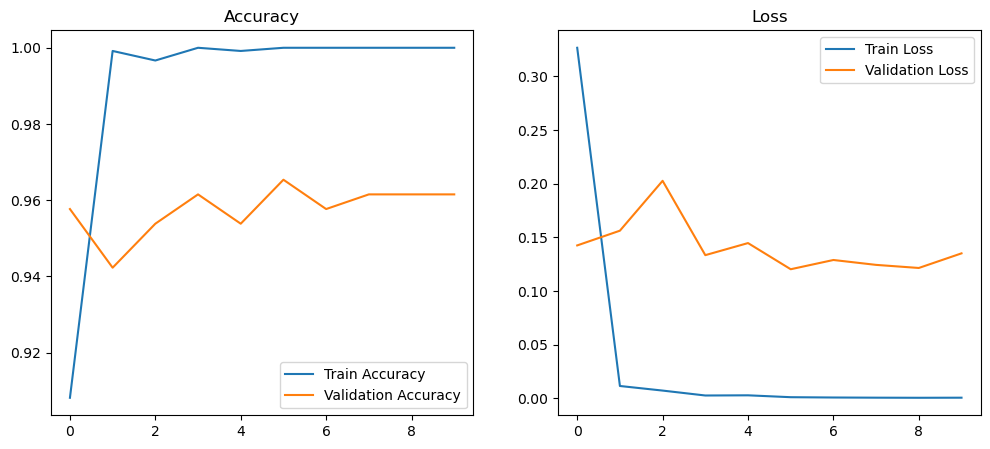

Classification Report:
                  precision    recall  f1-score   support

bacterial_blight       0.86      1.00      0.92        67
      curl_virus       0.92      0.98      0.95        62
  fussarium_wilt       0.98      0.74      0.84        62
         healthy       1.00      1.00      1.00        64

        accuracy                           0.93       255
       macro avg       0.94      0.93      0.93       255
    weighted avg       0.94      0.93      0.93       255



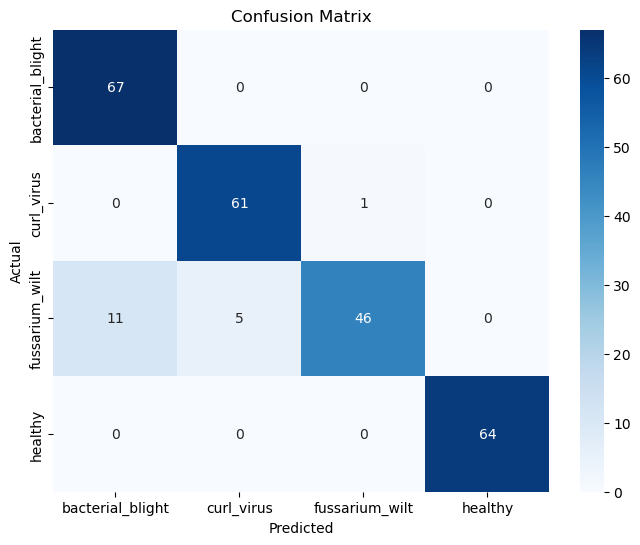

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data paths (Modify these to your dataset location)
data_dir = "C:/Users/Girish/OneDrive/Documents/PROJ_SYN_COTTON-20250214T162900Z-001/PROJ_SYN_COTTON/Real_Data"
train_dir = data_dir + "/train"
val_dir = data_dir + "/val"
test_dir = data_dir + "/test"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Pretrained ConvNeXt model
model = models.convnext_tiny(pretrained=True)
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, len(train_dataset.classes))  # Adjust output layer
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        epoch_train_acc = correct / total
        epoch_train_loss = running_loss / len(train_loader)
        train_acc.append(epoch_train_acc)
        train_loss.append(epoch_train_loss)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)

        epoch_val_acc = correct / total
        epoch_val_loss = running_loss / len(val_loader)
        val_acc.append(epoch_val_acc)
        val_loss.append(epoch_val_loss)

        print(f"Epoch {epoch+1}: Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")

    return train_acc, val_acc, train_loss, val_loss

# Train the model
train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Testing
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute Precision, Recall, F1-score
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Using device: cpu


C:\Users\Girish\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Girish\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc: 0.9067, Val Acc: 1.0000
Epoch 2: Train Acc: 0.9974, Val Acc: 1.0000
Epoch 3: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 4: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 5: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 6: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 7: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 8: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 9: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 10: Train Acc: 1.0000, Val Acc: 1.0000


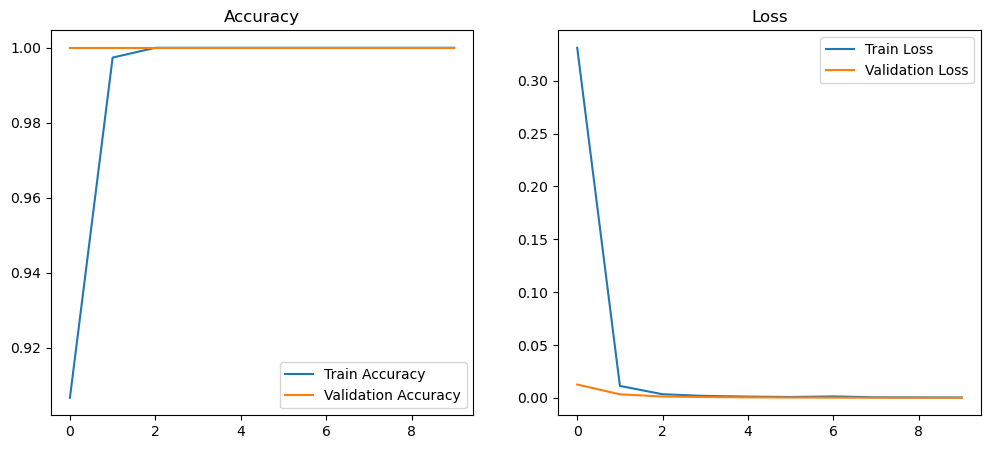

Classification Report:
                  precision    recall  f1-score   support

bacterial_blight       1.00      1.00      1.00       114
            curl       0.99      1.00      1.00       106
  fussarium_wilt       1.00      1.00      1.00       107
         healthy       1.00      0.99      1.00       108

        accuracy                           1.00       435
       macro avg       1.00      1.00      1.00       435
    weighted avg       1.00      1.00      1.00       435



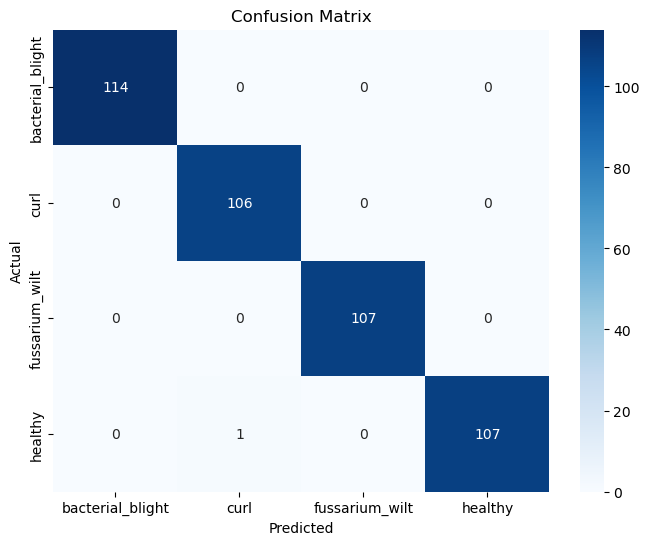

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data paths (Modify these to your dataset location)
data_dir = "C:/Users/Girish/OneDrive/Documents/PROJ_SYN_COTTON-20250214T162900Z-001/PROJ_SYN_COTTON/DATA"
train_dir = data_dir + "/train"
val_dir = data_dir + "/val"
test_dir = data_dir + "/test"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Pretrained ConvNeXt model
model = models.convnext_tiny(pretrained=True)
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, len(train_dataset.classes))  # Adjust output layer
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        epoch_train_acc = correct / total
        epoch_train_loss = running_loss / len(train_loader)
        train_acc.append(epoch_train_acc)
        train_loss.append(epoch_train_loss)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)

        epoch_val_acc = correct / total
        epoch_val_loss = running_loss / len(val_loader)
        val_acc.append(epoch_val_acc)
        val_loss.append(epoch_val_loss)

        print(f"Epoch {epoch+1}: Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")

    return train_acc, val_acc, train_loss, val_loss

# Train the model
train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Testing
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute Precision, Recall, F1-score
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Using device: cpu
⚠️ No saved model found. Running with randomly initialized weights.


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.49MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.68MB/s]



📊 Model Evaluation Metrics:
Accuracy : 0.1457
Precision: 0.0898
Recall   : 0.1457
F1 Score : 0.0818


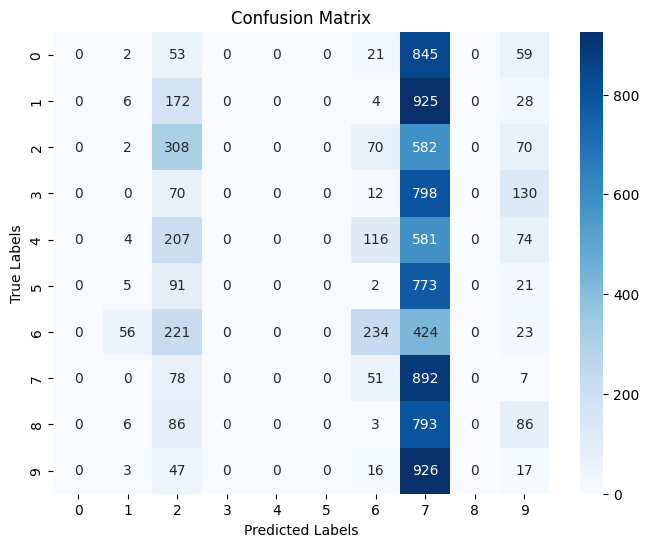


Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.07      0.01      0.01      1135
           2       0.23      0.30      0.26      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.44      0.24      0.31       958
           7       0.12      0.87      0.21      1028
           8       0.00      0.00      0.00       974
           9       0.03      0.02      0.02      1009

    accuracy                           0.15     10000
   macro avg       0.09      0.14      0.08     10000
weighted avg       0.09      0.15      0.08     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 1. Device Setup
# -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------------
# 2. Define Your Model Architecture
# -------------------------------
# (Modify this part to match your trained model)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------------------
# 3. Initialize and Load the Model
# -------------------------------
model = SimpleCNN().to(device)

# Load trained weights (replace 'model.pth' with your saved model file)
# Comment this line if you haven't trained/saved a model yet
try:
    model.load_state_dict(torch.load('model.pth', map_location=device))
    print("✅ Model weights loaded successfully!")
except FileNotFoundError:
    print("⚠️ No saved model found. Running with randomly initialized weights.")

model.eval()  # Set to evaluation mode

# -------------------------------
# 4. Load Your Test Data
# -------------------------------
# Example: MNIST test dataset
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# -------------------------------
# 5. Run Model Evaluation
# -------------------------------
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# -------------------------------
# 6. Compute Metrics
# -------------------------------
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

test_accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print("\n📊 Model Evaluation Metrics:")
print(f"Accuracy : {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# -------------------------------
# 7. Confusion Matrix
# -------------------------------
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# -------------------------------
# 8. Classification Report (Optional)
# -------------------------------
print("\nDetailed Classification Report:\n")
print(classification_report(true_labels, predicted_labels))
